In [13]:
import pandas as pd
import seaborn as sns
import numpy as np
import os


DATA_DIR = '../data/seattle'

df_calendar = pd.read_parquet(os.path.join(DATA_DIR, 'calendar.parquet'))
df_listings = pd.read_parquet(os.path.join(DATA_DIR, 'listings.parquet'))
df_reviews = pd.read_parquet(os.path.join(DATA_DIR, 'reviews.parquet'))

display('df_calendar',df_calendar.head(2))
display('df_listings',df_listings.head(2)) 
display('df_reviews',df_reviews.head(2))

'df_calendar'

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,9419,2024-12-23,f,$62.00,NaN,2,90
1,9419,2024-12-24,f,$62.00,NaN,2,90


'df_listings'

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,6606,https://www.airbnb.com/rooms/6606,20241223022600,2024-12-23,city scrape,"Fab, private seattle urban cottage!","This tiny cottage is only 15x10, but it has ev...","A peaceful yet highly accessible neighborhood,...",https://a0.muscache.com/pictures/45742/21116d7...,14942,...,4.77,4.88,4.57,str-opli-19-002622,f,2,2,0,0,0.86
1,9419,https://www.airbnb.com/rooms/9419,20241223022600,2024-12-23,city scrape,Glorious sun room w/ memory foambed,This beautiful double room features sun filled...,"Lots of restaurants (see our guide book) bars,...",https://a0.muscache.com/pictures/56645186/e5fb...,30559,...,4.89,4.68,4.67,Exempt,f,11,0,11,0,1.19


'df_reviews'

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,9419,71022,2010-07-30,166478,Beth,"If you love art, animals, and yoga, this is th..."
1,9419,83099,2010-08-23,165949,Erica,I only overnighted here but I loved the offbea...


In [4]:
!which python # Should be /Users/aus10powell/opt/anaconda3/bin/python

/Users/aus10powell/Documents/Projects/AirRanker/venv/bin/python


### Reviews

Reviews per user summary statistics:
count    454082.000000
mean          1.159665
std           0.685782
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          73.000000
Name: count, dtype: float64

Percentage of users by review count:
Users with exactly 1 review(s): 89.8%
Users with exactly 2 review(s): 7.4%
Users with exactly 3 review(s): 1.6%
Users with exactly 5 review(s): 0.3%
Users with exactly 10 review(s): 0.0%

Percentage of users with only 1 review: 89.8%


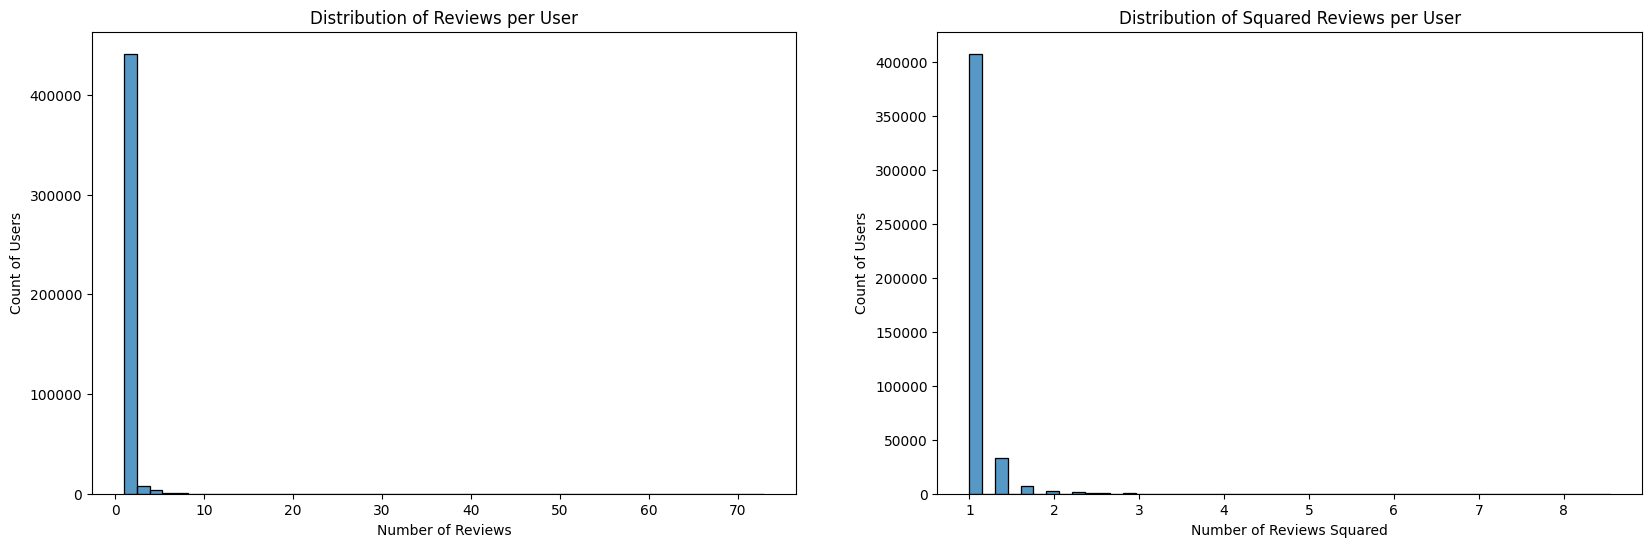

In [14]:
# Number of reviews per user distribution
# Calculate reviews per user
reviews_per_user = df_reviews['reviewer_id'].value_counts()

# Create distribution plots
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 6))

# Original distribution
plt.subplot(1, 2, 1)
sns.histplot(data=reviews_per_user, bins=50)
plt.title('Distribution of Reviews per User')
plt.xlabel('Number of Reviews')
plt.ylabel('Count of Users')

# Squared distribution 
plt.subplot(1, 2, 2)
sns.histplot(data=np.sqrt(reviews_per_user), bins=50)
plt.title('Distribution of Squared Reviews per User')
plt.xlabel('Number of Reviews Squared')
plt.ylabel('Count of Users')

# Print summary statistics
print("Reviews per user summary statistics:")
print(reviews_per_user.describe())

# Show percentage of users with different review counts
print("\nPercentage of users by review count:")
for n in [1, 2, 3, 5, 10]:
    pct = (reviews_per_user == n).mean() * 100
    print(f"Users with exactly {n} review(s): {pct:.1f}%")

pct_single = (reviews_per_user == 1).mean() * 100
print(f"\nPercentage of users with only 1 review: {pct_single:.1f}%")
